In [3]:
# %matplotlib notebook # comment this line when working in VSCode
import aipy, uvtools
import numpy as np
import pylab as plt
import random
import math
import os.path

from hera_sim import foregrounds, noise, sigchain, rfi, simulate

/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/anaconda3/lib/python3.6/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the wa

In [4]:
# from jupyterthemes import jtplot
# jtplot.style('grade3')

In [5]:
def get_k_rand_nums(start, stop, k):
    return sorted([random.uniform(start, stop) for x in range(k)])

def plot_one_vis(vis, ylim):
    plt.figure()
    plt.subplot(211); uvtools.plot.waterfall(vis, mode='log', mx=MX, drng=DRNG); plt.colorbar(); plt.ylim(0,ylim)
    plt.subplot(212); uvtools.plot.waterfall(vis, mode='phs'); plt.colorbar(); plt.ylim(0,ylim)
    plt.show()

MX, DRNG = 2.5, 3


# Generate a waterfall plot
Stored in `vis`

In [6]:
# ORIGINAL
lsts = np.linspace(1,2*np.pi,4000, endpoint=False) # local sidereal times; start range, stop range, number of snapshots
fqs = np.linspace(.1,.2,1024,endpoint=False) # frequencies in GHz
# times = lsts / (2*np.pi) * aipy.const.sidereal_day 
bl_len_ns = np.array([30.,0,0]) # ENU coordinates

### Generate point source foreground

In [7]:
# foregrounds.pntsrc_foreground?

/anaconda3/lib/python3.6/site-packages/uvtools/plot.py:40: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


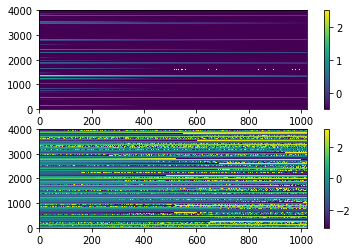

In [8]:
vis = foregrounds.pntsrc_foreground(lsts, fqs, bl_len_ns, nsrcs=200)

plot_one_vis(vis, 4000)

In [9]:
vis.shape

(4000, 1024)

### Generate diffuse source foreground

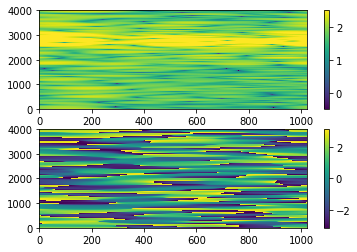

In [10]:
# bl_len_ns = np.array([30.])
Tsky_mdl = noise.HERA_Tsky_mdl['xx']
vis = vis + foregrounds.diffuse_foreground(lsts, fqs, bl_len_ns, Tsky_mdl) # add diffuse FG

MX, DRNG = 2.5, 3
plot_one_vis(vis, 4000)

### Generate and shuffle RFI

In [11]:
# rfi.rfi_stations?

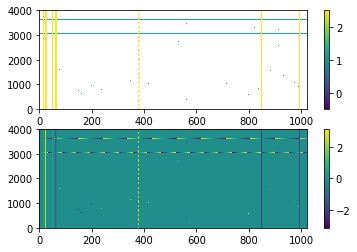

In [12]:
rfi1 = rfi.rfi_stations(fqs, lsts) # Default list of stations: rfi.HERA_RFI_STATIONS
rfi2 = rfi.rfi_impulse(fqs, lsts, chance=.02) # ORIGINAL: .02
rfi3 = rfi.rfi_scatter(fqs, lsts, chance=.001) # ORIGINAL: .001
rfi_all = rfi1 + rfi2 + rfi3

plot_one_vis(rfi_all, 4000)


In [13]:
# This function will be called on an individual waterfall plot
def add_random_rfi(plot):
    np.random.shuffle(rfi_all.T)
    return plot + rfi_all

### Generate noise
Should have variations!

In [14]:
# noise.sky_noise_jy?

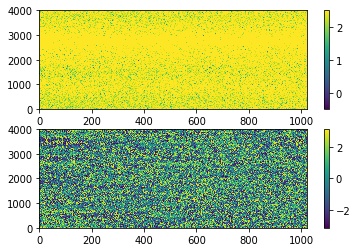

In [43]:
tsky = noise.resample_Tsky(fqs,lsts,Tsky_mdl=noise.HERA_Tsky_mdl['xx'])
t_rx = 150.
OMEGA_P = (0.72)*np.ones(1024) 
# .72 or smaller for omega_p; provided by Adrian, from literature

nos_jy = noise.sky_noise_jy(tsky + t_rx, fqs, lsts, OMEGA_P)
vis = vis + nos_jy
plot_one_vis(vis, 4000)

In [41]:
print(vis.shape)
dataset = np.array(np.split(vis, 200, axis=0))
print(dataset.shape)

(4000, 1024)
(200, 20, 1024)


### Gain and Crosstalk

In [16]:
#####################
# TO BE ADDED
#####################

# Generate dataset

Layer one visibility plot with `m` different RFI shuffles, then split each version (including the original untainted plot) into `l` data points, for a total dataset size of `(m+1)*l`.

In [88]:
def generate_dataset(vis, l, m):
    # Split clean plot by lst and add to dataset
    # e.g. (4000, 1024) => l arrays of size (4000/l, 1024)
    dataset = np.array(np.split(vis, l))
    zeros = np.zeros(l, dtype=int)
    labels = zeros # add labels

    # Add m different RFI shuffles, then split and add to dataset
    for j in range(m):
        temp = add_random_rfi(vis)
        dataset = np.concatenate((dataset, np.split(temp, l)))
        labels = np.concatenate((labels, np.ones(l, dtype=int)))
    
    #################################################################
    # COMMENT OUT BELOW LINES IF NOT SEPARATING DATA INTO COMPONENTS
    
    # Separate and concatenate real/imag components of the dataset
    dim1 = dataset.shape[0] # e.g. 1200
    dim2 = dataset.shape[1] # e.g. 20
    dim3 = dataset.shape[2] # e.g. 1024 ==> 2048

    temp = np.zeros((dim1, dim2, dim3*2))
    for i in range(dim1):
        for j in range(dim2):
            cp = dataset[i][j] # complex value
            temp[i][j][0:dim3] = cp.real
            temp[i][j][dim3:dim3*2] = cp.imag

    dataset = temp
    #################################################################
    
    # Export data
    i = 1
    while(os.path.isfile(f'dataset{i}.npy')):
        i = i+1
    np.save(f'dataset{i}.npy', dataset)
    np.save(f'labels{i}.npy', labels)
    if len(dataset) == len(labels):
        print(f'Dataset of size {len(dataset)} exported as `dataset{i}.npy`.')
    
    return dataset
    

In [89]:
data = generate_dataset(vis, 200, 5)

Dataset of size 1200 exported as `dataset1.npy`.
